In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-06-02 12:11:29.200289: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 12:11:29.200386: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 12:11:29.361638: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/34 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N20.JPG
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N1.JPG
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/49 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N15.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/No18.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/31 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/no 6.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/3 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/no 5.jpeg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/no 1.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/26 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N26.JPG
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N5.jpg
/kaggle/input/brain-mri-images-for-b

#  Using ImageDataGenerator to load images directly from the given directories and split them into training and validation sets.

## Define Image Paths and Parameters

In [2]:
no_tumor_dir = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/no'
yes_tumor_dir = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes'

In [3]:
img_height, img_width = 150, 150
batch_size = 32
epochs = 10

# Prepare Image Data Generators

## Since you have separate directories for no and yes, we need to combine them into a single directory structure compatible with ImageDataGenerator. However,creating new directories might not be feasible. Instead, we can create a custom DataFrame to handle this.

In [4]:
no_tumor_files = [os.path.join(no_tumor_dir, fname) for fname in os.listdir(no_tumor_dir)]
yes_tumor_files = [os.path.join(yes_tumor_dir, fname) for fname in os.listdir(yes_tumor_dir)]

In [5]:
data = pd.DataFrame({
    'filename': no_tumor_files + yes_tumor_files,
    'label': [0] * len(no_tumor_files) + [1] * len(yes_tumor_files)
})

In [6]:
train_df, val_df = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(train_df.head())
print(val_df.head())

                                            filename  label
0  /kaggle/input/brain-mri-images-for-brain-tumor...      0
1  /kaggle/input/brain-mri-images-for-brain-tumor...      0
2  /kaggle/input/brain-mri-images-for-brain-tumor...      0
3  /kaggle/input/brain-mri-images-for-brain-tumor...      1
4  /kaggle/input/brain-mri-images-for-brain-tumor...      0
                                            filename  label
0  /kaggle/input/brain-mri-images-for-brain-tumor...      0
1  /kaggle/input/brain-mri-images-for-brain-tumor...      1
2  /kaggle/input/brain-mri-images-for-brain-tumor...      0
3  /kaggle/input/brain-mri-images-for-brain-tumor...      1
4  /kaggle/input/brain-mri-images-for-brain-tumor...      0


# Define Custom Data Generators

## We need custom data generators to handle DataFrame inputs.

In [7]:
class DataFrameImageGenerator(Sequence):
    def __init__(self, dataframe, batch_size, img_size, shuffle=True):
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(len(self.dataframe) // self.batch_size)

    def __getitem__(self, index):
        batch = self.dataframe[index * self.batch_size:(index + 1) * self.batch_size]
        images = []
        labels = []
        for _, row in batch.iterrows():
            img = load_img(row['filename'], target_size=self.img_size)
            img = img_to_array(img) / 255.0
            images.append(img)
            labels.append(row['label'])
        return tf.convert_to_tensor(images), tf.convert_to_tensor(labels)

    def on_epoch_end(self):
        if self.shuffle:
            self.dataframe = self.dataframe.sample(frac=1).reset_index(drop=True)

In [8]:
train_generator = DataFrameImageGenerator(train_df, batch_size, (img_height, img_width))
val_generator = DataFrameImageGenerator(val_df, batch_size, (img_height, img_width))

#  Build the CNN Model

In [9]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

# Train the Model

In [10]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4473 - loss: 0.9633 

I0000 00:00:1717330324.007140      70 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717330324.025995      70 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


6/6 ━━━━━━━━━━━━━━━━━━━━ 23s 774ms/step - accuracy: 0.4666 - loss: 0.9172 - val_accuracy: 0.6875 - val_loss: 0.6640
Epoch 2/10


W0000 00:00:1717330327.902726      69 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 358ms/step - accuracy: 0.7551 - loss: 0.6109 - val_accuracy: 0.7500 - val_loss: 0.5949
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 341ms/step - accuracy: 0.7954 - loss: 0.5124 - val_accuracy: 0.8125 - val_loss: 0.5954
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 338ms/step - accuracy: 0.7438 - loss: 0.4965 - val_accuracy: 0.8125 - val_loss: 0.4611
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 342ms/step - accuracy: 0.7946 - loss: 0.4347 - val_accuracy: 0.7188 - val_loss: 0.7126
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 337ms/step - accuracy: 0.7880 - loss: 0.4726 - val_accuracy: 0.7188 - val_loss: 0.6246
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.7906 - loss: 0.4904 - val_accuracy: 0.7188 - val_loss: 0.6525
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 343ms/step - accuracy: 0.8151 - loss: 0.3984 - val_accuracy: 0.6562 - val_loss: 0.7194
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 339ms/step - accuracy: 0.8579 - loss: 0.3350 - val_accuracy: 0.7812 - val_loss: 0.

# Visualize Training Results

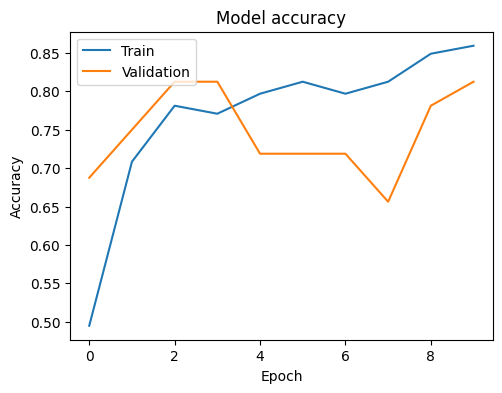

In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

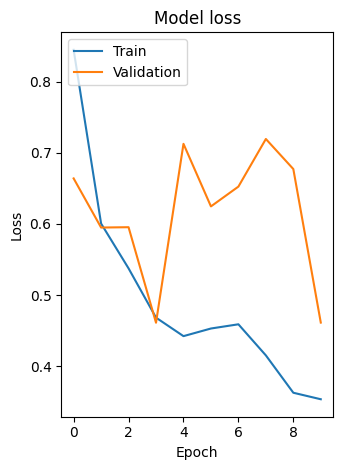

In [12]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()